# Julia Unfold test

## Create Julia enviroment

This will install Julia lang in the current enviroment, if not installed yet.

In [ ]:
# Import the Julia package manager
from juliacall import Pkg as jlPkg

# Activate the environment in the current folder
jlPkg.activate(".")

# Check the status of the environment/installed packages -> will be empty at the beginning
print(jlPkg.status())

# Install Julia packages
jlPkg.add("Unfold")
jlPkg.add("DataFrames")
jlPkg.add("CSV")
jlPkg.add("UnfoldMakie")
jlPkg.add("CairoMakie")
jlPkg.add("StatsModels")
jlPkg.add("MixedModels")
jlPkg.add("DSP")
jlPkg.add("UnfoldSim")

Import Julia packages

In [ ]:
from juliacall import Main as jl

jl.seval("using DataFrames")
jl.seval("using Unfold")
jl.seval("using UnfoldSim")
jl.seval("using UnfoldMakie, CairoMakie")
jl.seval("using StatsModels")
jl.seval("using MixedModels")

Unfold = jl.Unfold

jl.seval("include(joinpath(dirname(pathof(Unfold)), \"../test/test_utilities.jl\"))") # to load data

Import Python packages

In [6]:
from mne.datasets.limo import load_data
import pandas as pd
import seaborn as sns
import numpy as np
from mne import combine_evoked
from mne.datasets.limo import load_data
from mne.stats import linear_regression
from mne.viz import plot_compare_evokeds, plot_events
import matplotlib.pyplot as plt

## Load example dataset and create shifted simulated EEG

In [7]:
data, evts = jl.seval("UnfoldSim.predef_eeg()")

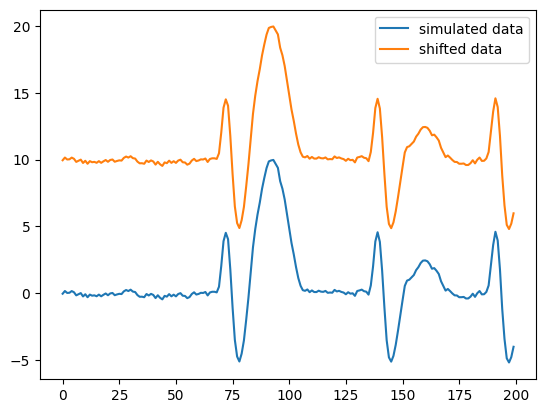

In [26]:
dat_py = list(data)
sns.lineplot(dat_py[:200], label='simulated data')

dat_py_shifted = np.array(data) + 10
sns.lineplot(dat_py_shifted[:200], label='shifted data')

plt.show()

## Specify formulas and basisfunctions

In [28]:
bf = jl.seval("basisfunction = firbasis(τ=(-0.4,.8), sfreq=100)")
formula1 = jl.seval("f1 = @formula 0 ~ 1 + condition + continuous")
bfDict = jl.seval("[ Any => (f1, basisfunction)]")

Model fitting

In [30]:
m_original = Unfold.fit(
    Unfold.UnfoldModel,
    bfDict,
    evts,
    data,
)

m_shifted = Unfold.fit(
    Unfold.UnfoldModel,
    bfDict,
    evts,
    dat_py_shifted,
)

In [31]:
results_original_jl = Unfold.coeftable(m_original)
results_shifted_jl = Unfold.coeftable(m_shifted)

In [32]:
def jl_results_to_python(results_jl):
    results_py_df = pd.DataFrame({
        'channel': results_jl.channel,
        'coefname': results_jl.coefname,
        'estimate': results_jl.estimate,
        'eventname': results_jl.eventname,
        'group': results_jl.group,
        'stderror': results_jl.stderror,
        'time': results_jl.time
    })
    return results_py_df    

In [33]:
# Transfer results back to Python
results_original = jl_results_to_python(results_original_jl)
results_shifted = jl_results_to_python(results_shifted_jl)

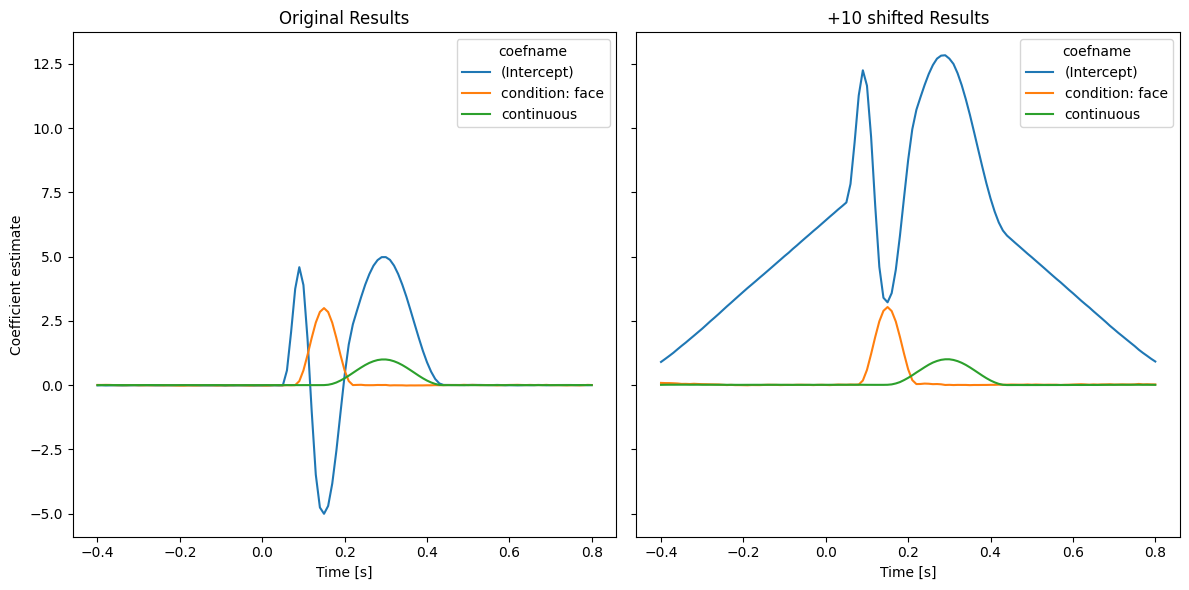

In [37]:
# Extract the coefficients for one channel
results_ch_original = results_original[results_original.channel == 1]
results_ch_shifted = results_shifted[results_shifted.channel == 1]

# Plot the coefficient estimates over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

ax1 = sns.lineplot(
    x = results_ch_original.time,
    y=results_ch_original.estimate,
    hue=results_ch_original.coefname,
    ax=ax1
)
ax1.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='Original Results')

ax2 = sns.lineplot(
    x = results_ch_shifted.time,
    y=results_ch_shifted.estimate,
    hue=results_ch_shifted.coefname,
    ax=ax2
)
ax2.set(xlabel='Time [s]', ylabel='Coefficient estimate', title='+10 shifted Results')

plt.tight_layout()
plt.show()

Plot exact clean waveforms of faces and houses

In [117]:
# Extract the coefficients for one channel
results_ch = results_py_df[results_py_df.channel == 1]

# Filter the DataFrame for 'i' and 'e' in the 'variable' column
filtered_df = results_ch[results_ch['coefname'].isin(['condition: face', '(Intercept)'])]
# Group by the 'time' column and sum the 'estimate' values
grouped_df = filtered_df.groupby('time', as_index=False)['estimate'].sum()

<Axes: xlabel='time', ylabel='estimate'>

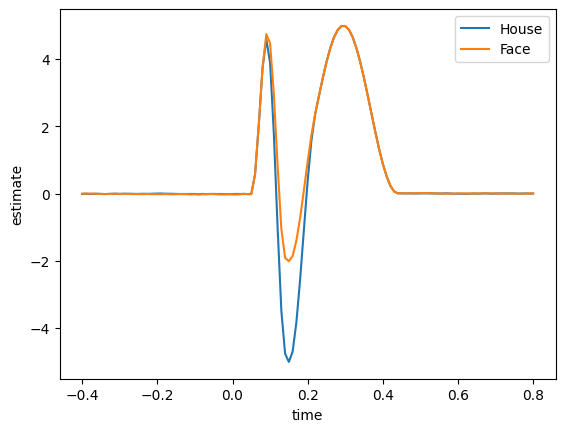

In [122]:
sns.lineplot(
    x = results_ch.time,
    y=results_ch[results_ch['coefname'] == '(Intercept)'].estimate, 
    label='House'
)
sns.lineplot(
    x = grouped_df.time,
    y=grouped_df.estimate,
    label='Face'
)